# Emotions Melody

# 環境設定

In [3]:
from time import sleep
import time
import datetime
import os
import csv
import glob
import collections
import re
import glob
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pretty_midi
import shutil
import random
import music21 as m21
import mido 
from mido import Message, MidiFile, MidiTrack, MetaMessage

from transformers import pipeline 
from transformers import AutoModelForSequenceClassification 
from transformers import BertJapaneseTokenizer
model = AutoModelForSequenceClassification.from_pretrained('daigo/bert-base-japanese-sentiment')
tokenizer = BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

datafolder = "data/02_file/emotion_rank_list/"
emotion_rank_list = datafolder + "emotion_rank_list.csv"
data = pd.DataFrame(pd.read_csv(emotion_rank_list))
genefolder_pr = "data/03_chord/chord_pr/"
genefolder_sc = "data/03_chord/score/"


maj_chord_tables=[['C',{'Ⅰ':'C','Ⅱ':'D','Ⅲ':'E','Ⅳ':'F','Ⅴ':'G','Ⅵ':'A','Ⅶ':'B'}],
                  ['G',{'Ⅰ':'G','Ⅱ':'A','Ⅲ':'B','Ⅳ':'C','Ⅴ':'D','Ⅵ':'E','Ⅶ':'F#'}],
                  ['D',{'Ⅰ':'D','Ⅱ':'E','Ⅲ':'F#','Ⅳ':'G','Ⅴ':'A','Ⅵ':'B','Ⅶ':'C#'}],
                  ['A',{'Ⅰ':'A','Ⅱ':'B','Ⅲ':'C#','Ⅳ':'D','Ⅴ':'E','Ⅵ':'F#','Ⅶ':'G#'}],
                  ['E',{'Ⅰ':'E','Ⅱ':'F#','Ⅲ':'G#','Ⅳ':'A#','Ⅴ':'B','Ⅵ':'C#','Ⅶ':'D'}],
                  ['B',{'Ⅰ':'B','Ⅱ':'C#','Ⅲ':'D#','Ⅳ':'E','Ⅴ':'F#','Ⅵ':'G#','Ⅶ':'A#'}],
                  ['F#',{'Ⅰ':'F#','Ⅱ':'G#','Ⅲ':'A#','Ⅳ':'B','Ⅴ':'C#','Ⅵ':'D#','Ⅶ':'E#'}],
                  ['C#',{'Ⅰ':'C#','Ⅱ':'D#','Ⅲ':'E#','Ⅳ':'F#','Ⅴ':'G#','Ⅵ':'A#','Ⅶ':'B#'}],
                  ['F',{'Ⅰ':'F','Ⅱ':'G','Ⅲ':'A','Ⅳ':'Bb','Ⅴ':'C','Ⅵ':'D','Ⅶ':'E'}],
                  ['Bb',{'Ⅰ':'Bb','Ⅱ':'C','Ⅲ':'D','Ⅳ':'Eb','Ⅴ':'F','Ⅵ':'G','Ⅶ':'A'}],
                  ['Eb',{'Ⅰ':'Eb','Ⅱ':'F','Ⅲ':'G','Ⅳ':'Ab','Ⅴ':'Bb','Ⅵ':'C','Ⅶ':'D'}],
                  ['Ab',{'Ⅰ':'Ab','Ⅱ':'Bb','Ⅲ':'C','Ⅳ':'Db','Ⅴ':'Eb','Ⅵ':'F','Ⅶ':'G'}],
                  ['Db',{'Ⅰ':'Db','Ⅱ':'Eb','Ⅲ':'F','Ⅳ':'Gb','Ⅴ':'Ab','Ⅵ':'Bb','Ⅶ':'C'}],
                  ['Gb',{'Ⅰ':'Gb','Ⅱ':'Ab','Ⅲ':'Bb','Ⅳ':'Cb','Ⅴ':'Db','Ⅵ':'Eb','Ⅶ':'F'}],
                  ['Cb',{'Ⅰ':'Cb','Ⅱ':'Db','Ⅲ':'Eb','Ⅳ':'Fb','Ⅴ':'Gb','Ⅵ':'Ab','Ⅶ':'Bb'}]]

maj_data = pd.DataFrame(maj_chord_tables, columns=['key_table','chord_dic']).set_index('key_table')

def text_to_chord(key,Target_TXT):
    result = nlp(Target_TXT)
    if result[0]['label'] == "ネガティブ":
        num = result[0]['score'] * -1
    else:
        num = result[0]['score']
    
    # 指定値に最も近い値のインデックスを取得
    distance = np.abs(data['score']-num)
    indices = np.where(distance == np.min(distance))[0]
    text_list = data['chord'][np.random.choice(indices)]

    no = maj_data.index.get_loc(key)
    dic = maj_data['chord_dic'][no]    
    
    transed = []
    transed = [dic.get(moji, moji) for moji in text_list]
    chord_pr = ''.join(transed).lstrip(' ')
    chord_pr = chord_pr.replace("bC","B")
    chord_pr = chord_pr.replace("bD","Db")
    chord_pr = chord_pr.replace("bE","Eb")
    chord_pr = chord_pr.replace("bF","E")
    chord_pr = chord_pr.replace("bG","Gb")
    chord_pr = chord_pr.replace("bA","Ab")
    chord_pr = chord_pr.replace("bB","Bb")
    chord_pr = chord_pr.replace("E#","F")
    chord_pr = chord_pr.replace("B#","C")
    chord_pr = chord_pr.replace("C##","D")
    chord_pr = chord_pr.replace("D##","E")
    chord_pr = chord_pr.replace("F##","G")
    chord_pr = chord_pr.replace("G##","A")
    chord_pr = chord_pr.replace("A##","B")
    chord_pr = chord_pr.replace("Cbb","Bb")
    chord_pr = chord_pr.replace("Dbb","C")
    chord_pr = chord_pr.replace("Ebb","D")
    chord_pr = chord_pr.replace("Fbb","Eb")
    chord_pr = chord_pr.replace("Gbb","F")
    chord_pr = chord_pr.replace("Abb","G")
    chord_pr = chord_pr.replace("Bbb","A")
    chord_pr = chord_pr.replace("Cb#","C")
    chord_pr = chord_pr.replace("Db#","D")
    chord_pr = chord_pr.replace("Eb#","E")
    chord_pr = chord_pr.replace("Fb#","F")
    chord_pr = chord_pr.replace("Gb#","G")
    chord_pr = chord_pr.replace("Ab#","A")
    chord_pr = chord_pr.replace("Bb#","B")
    
    if "la" not in Target_TXT:
        if 0 <= chord_pr.count(" ") <= 2:
            chord_pr = chord_pr + " " + chord_pr
    
    date_now = datetime.datetime.now()
    filename_ch = genefolder_pr + "chord_fw_" + date_now.strftime('%Y%m%d_%H%M%S%f')
    with open(filename_ch, "w", encoding="UTF-8") as txt:
        txt.write(chord_pr)
    
    filename_sc = genefolder_sc + "score_" + date_now.strftime('%Y%m%d_%H%M%S%f')
    with open(filename_sc, "w", encoding="UTF-8") as txt:
        txt.write(str(num))
    
    print(Target_TXT,":",chord_pr)
    print("")

ModuleNotFoundError: No module named 'pandas'

# 詩をコードに変換

In [5]:
shutil.rmtree(genefolder_pr)
os.mkdir(genefolder_pr)    

shutil.rmtree(genefolder_sc)
os.mkdir(genefolder_sc)    

#ボブ・ディラン　風に吹かれて
text_to_chord("D","la3")
text_to_chord("D","人は何度見上げれば空が見えるのか")
text_to_chord("D","人にはいくつ耳があれば人々の悲しみが聞こえるのか")
text_to_chord("D","どれ位の人が死んだら")
text_to_chord("D","あまりにも多くの人が亡くなったことに気づくのか")
text_to_chord("D","友よ答えは風に吹かれて")
text_to_chord("D","風に吹かれている")
text_to_chord("D","la3")

la3 : A B C#m7

人は何度見上げれば空が見えるのか : Emaj7 D#m7 Emaj7 D#m7

人にはいくつ耳があれば人々の悲しみが聞こえるのか : G F#7 Bm Am D

どれ位の人が死んだら : Dmaj7 A/C# Bm Dm

あまりにも多くの人が亡くなったことに気づくのか : G A D G A D

友よ答えは風に吹かれて : G#/C A#m G# G#/C A#m G#

風に吹かれている : Bm F#/Bb Bm F#/Bb

la3 : G A Bm7



# Magentaでメロディを生成

/Users/hanyanoriaki/Desktop/emotions-melody-app/env/lib/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/Users/hanyanoriaki/Desktop/emotions-melody-app/env/lib/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/Users/hanyanoriaki/Desktop/emotions-melody-app/env/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or a

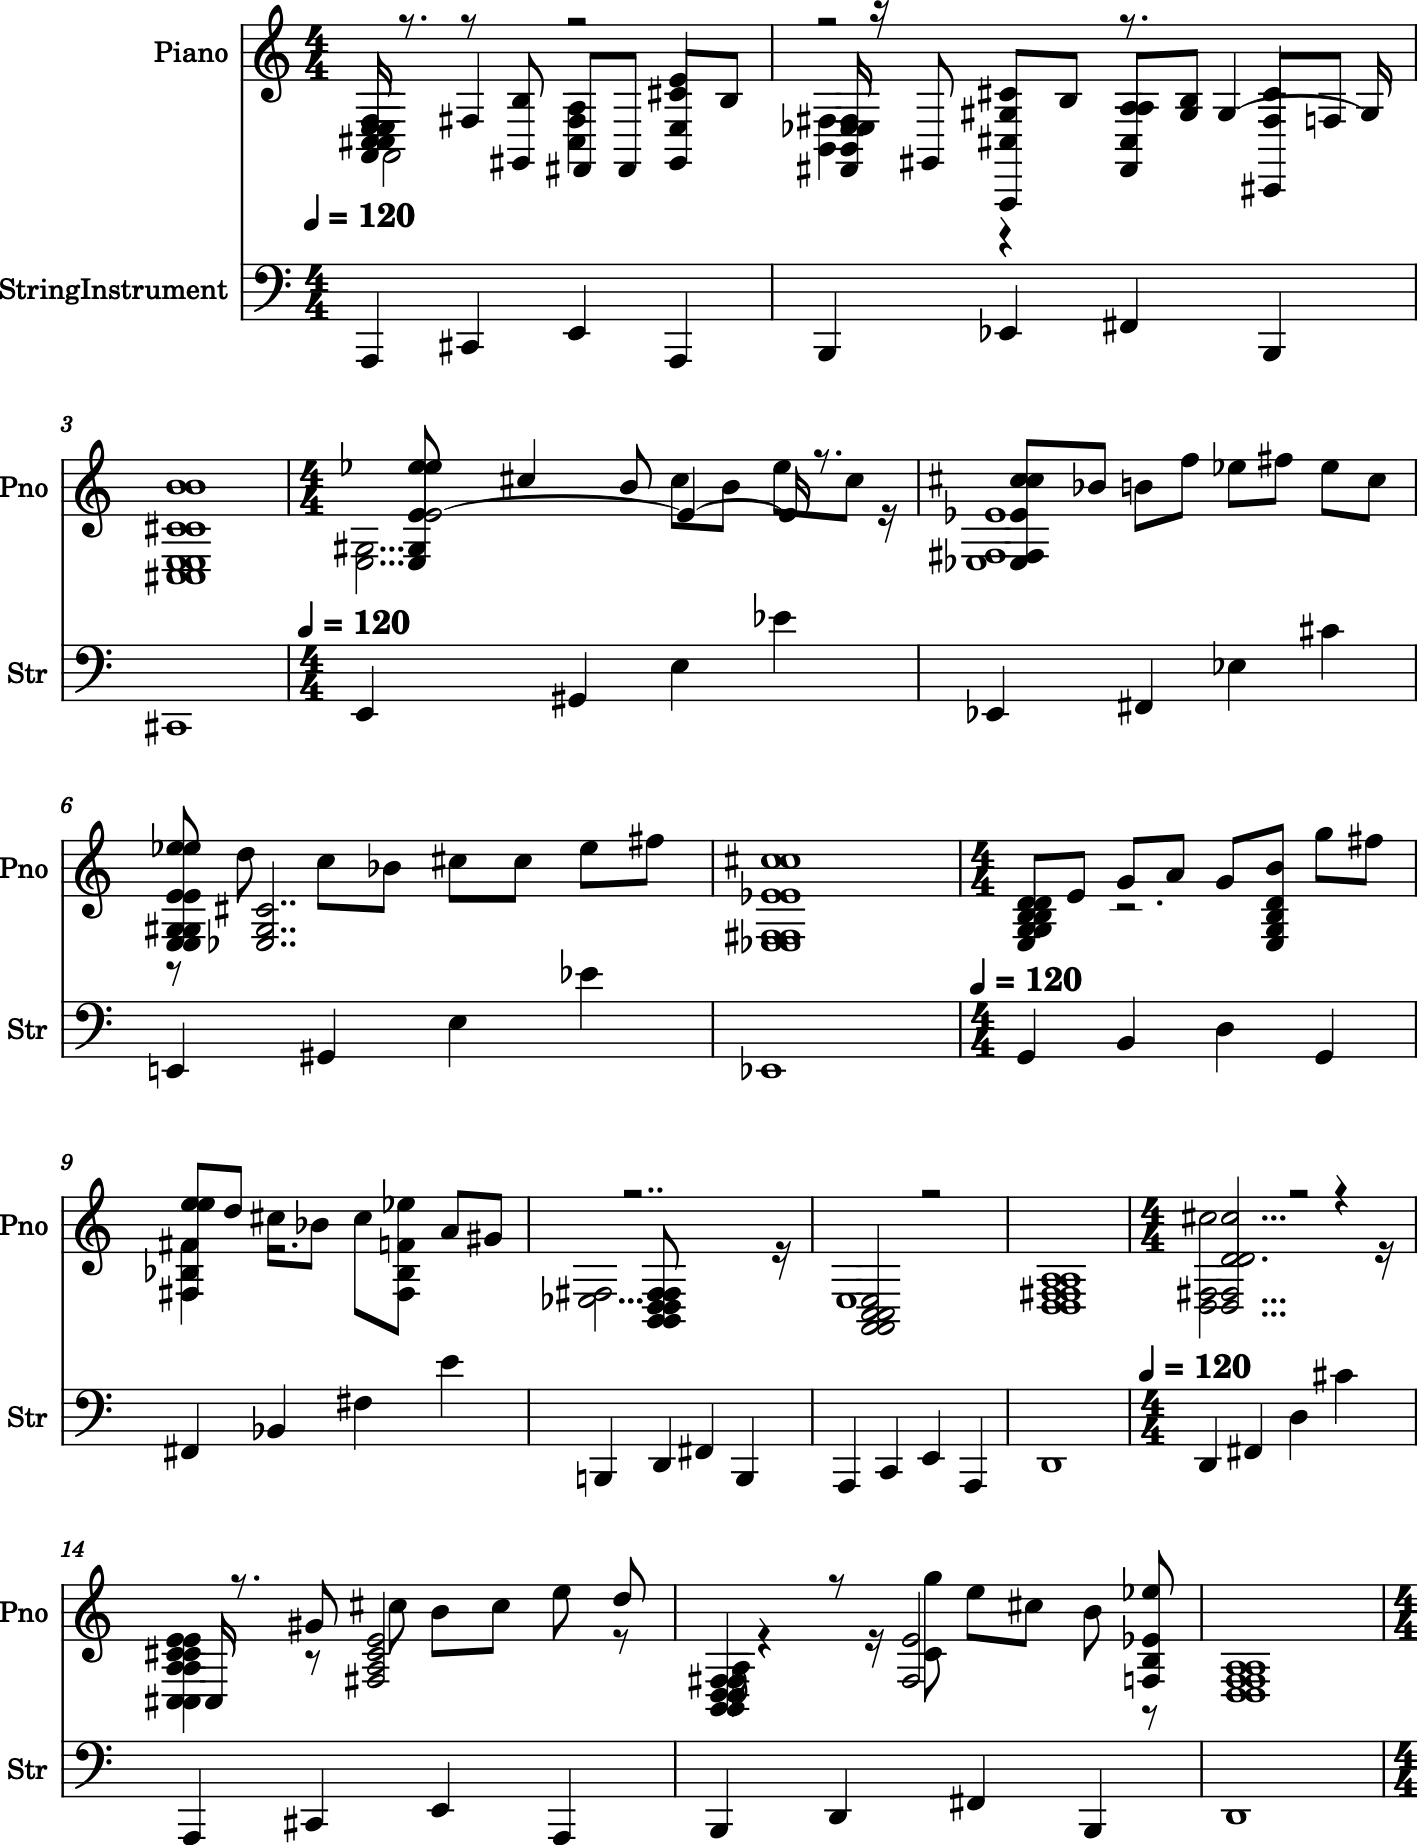

In [6]:
midi_folder_p = "data/04_chord_midi/piano/"
midi_folder_b = "data/04_chord_midi/bass/"

#magentaへ渡すコード進行をMidiに変換
def chord2midi_p(lyric_chord):
    root        = {'C':0,
                   'C#':1,
                   'Db':1,
                   'D':2,
                   'D#':3,
                   'Eb':3,
                   'E':4,
                   'E#':5,
                   'F':5,
                   'F#':6,
                   'Gb':6,
                   'G':7,
                   'G#':8,
                   'Ab':8,
                   'A':-3,
                   'A#':-2,
                   'Bb':-2,
                   'B':-1,}

    chord_type = {'':np.array([0, 4, 7]),
                  'm':np.array([0, 3, 7]),
                  '7':np.array([0, 4, 12, 22]),
                  'm7':np.array([0, 3, 12, 22]),
                  'mM7':np.array([0, 3, 12, 23]),
                  'maj7':np.array([0, 4, 12, 23]),
                  'dim':np.array([0, 3, 6, 9, 12]),
                  'aug':np.array([0, 4, 8, 12]),
                  'add9':np.array([0, 4, 12, 26]),
                  'sus4':np.array([0, 5, 7, 12]),
                  '7sus4':np.array([0, 5, 12, 22]),
                  'm6':np.array([0, 3, 12, 21]),
                  '6':np.array([0, 4, 12, 21]),
                  'm7-5':np.array([0, 3, 6, 12, 22]),
                  'm6':np.array([0, 3, 12, 21]),
                  '9':np.array([0, 4, 7, 22, 25]),}
    
    on_chord = {'/Cb':47,
                '/C':48,
                '/C#':49,
                '/Db':49,
                '/D':50,
                '/D#':51,
                '/Eb':51,
                '/E':52,
                '/Fb':52,
                '/E#':53,
                '/F':53,
                '/F#':54,
                '/Gb':54,
                '/G':55,
                '/G#':56,
                '/Ab':56,
                '/A':57,
                '/A#':58,
                '/Bb':58,
                '/B':59,}


    def split_chord(chord):
        j=chord    
        c=j
        o=j
        if '/' in o:
            target = '/'
            idx = o.find(target)
            o = o[idx:]
        else:
            idx = ''
            o=''
        
        if len(c)>1:
            if idx != '':
                c=c[0:2]
                if c[1]=='#' or c[1]=='b':
                    c=c[0:2]
                    j=j[2:idx]
                else:
                    c=c[0:1]
                    j=j[1:idx]
            else:
                c=c[0:2]
                if c[1]=='#' or c[1]=='b':
                    c=c[0:2]
                    j=j[2:]
                else:
                    c=c[0:1]
                    j=j[1:]
        else:
            j=''
        return c, j, o

    pm_p = pretty_midi.PrettyMIDI(resolution=960, initial_tempo=120)
    instrument = pretty_midi.Instrument(0)
    
    imput_chords = open(os.path.expanduser(lyric_chord),'r').read()
    chords = np.array(re.split(" +", imput_chords.rstrip()))
    chords_len = len(chords)
    
    i = 0
    d_time_list = [0.125, 0.125, 0.125, 0.25, 0.25, 0.25, 0.5, 1.0, 1.0, 2.0] #コードを鳴らす間隔
    time = 0
    
    for chord in chords:
        i += 1
        croot, ctype, otype = split_chord(chord)
        #print(croot, ctype, otype)
        
        d_time = float(random.choice(d_time_list)) #コードを鳴らす間隔
        e_time = 2.0 - d_time
        
        if otype != "":
            notes = 60 + root[croot]
        else:
            notes = 48 + root[croot]
        
        if otype != "":
            if ctype in chord_type:
                notes += chord_type[ctype]
                notes = np.insert(notes, [0], on_chord[otype])
            else:
                notes += np.array([0, 12])
                notes = np.insert(notes, [0], on_chord[otype])
        else:
            if ctype in chord_type:
                notes += chord_type[ctype]
            else:
                notes += np.array([0, 12])
        
        if i == chords_len:
            d_time = 2.0
            for note_number in notes:
                note = pretty_midi.Note(velocity=100, pitch=note_number, start=time, end=time+d_time) 
                instrument.notes.append(note)
        else:
            for note_number in notes:
                note = pretty_midi.Note(velocity=80, pitch=note_number, start=time, end=time+d_time) 
                instrument.notes.append(note)
            for e_number in range(int(e_time/d_time+1)):
                note = pretty_midi.Note(velocity=0, pitch=0, start=time, end=time+d_time) 
                instrument.notes.append(note)
                time = time + d_time

    pm_p.instruments.append(instrument)
    
    filepath_p=midi_folder_p + "chords_" + str(l) + ".mid"
    pm_p.write(filepath_p)

#ベース音の作成
def chord2midi_b(lyric_chord):
    root        = {'C':0,
                   'C#':1,
                   'Db':1,
                   'D':2,
                   'D#':3,
                   'Eb':3,
                   'E':4,
                   'E#':5,
                   'F':5,
                   'F#':6,
                   'Gb':6,
                   'G':7,
                   'G#':8,
                   'Ab':8,
                   'A':-3,
                   'A#':-2,
                   'Bb':-2,
                   'B':-1,}

    chord_type = {'':np.array([0, 4, 7, 0]),
                  'm':np.array([0, 3, 7, 0]),
                  '7':np.array([0, 4, 12, 22]),
                  'm7':np.array([0, 3, 12, 22]),
                  'mM7':np.array([0, 3, 12, 23]),
                  'maj7':np.array([0, 4, 12, 23]),
                  'dim':np.array([0, 3, 6, 9]),
                  'aug':np.array([0, 4, 8, 12]),
                  'add9':np.array([0, 4, 12, 26]),
                  'sus4':np.array([0, 5, 7, 12]),
                  '7sus4':np.array([0, 5, 12, 22]),
                  'm6':np.array([0, 3, 12, 21]),
                  '6':np.array([0, 4, 12, 21]),
                  'm7-5':np.array([0, 3, 6, 12]),
                  'm6':np.array([0, 3, 12, 21]),
                  '9':np.array([0, 4, 7, 25]),}
    
    on_chord = {'/Cb':47,
                '/C':48,
                '/C#':49,
                '/Db':49,
                '/D':50,
                '/D#':51,
                '/Eb':51,
                '/E':52,
                '/Fb':52,
                '/E#':53,
                '/F':53,
                '/F#':54,
                '/Gb':54,
                '/G':55,
                '/G#':56,
                '/Ab':56,
                '/A':57,
                '/A#':58,
                '/Bb':58,
                '/B':59,}


    def split_chord(chord):
        j=chord    
        c=j
        o=j
        if '/' in o:
            target = '/'
            idx = o.find(target)
            o = o[idx:]
        else:
            idx = ''
            o=''
        
        if len(c)>1:
            if idx != '':
                c=c[0:2]
                if c[1]=='#' or c[1]=='b':
                    c=c[0:2]
                    j=j[2:idx]
                else:
                    c=c[0:1]
                    j=j[1:idx]
            else:
                c=c[0:2]
                if c[1]=='#' or c[1]=='b':
                    c=c[0:2]
                    j=j[2:]
                else:
                    c=c[0:1]
                    j=j[1:]
        else:
            j=''
        return c, j, o
    
    #ベース音の作成
    pm_b = pretty_midi.PrettyMIDI(resolution=960, initial_tempo=120, )
    instrument = pretty_midi.Instrument(48)
    
    imput_chords = open(os.path.expanduser(lyric_chord),'r').read()
    chords = np.array(re.split(" +", imput_chords.rstrip()))
    chords_len = len(chords)
    
    i = 0
    d_time_b = 0.5 #コードを鳴らす間隔
    time = 0
    
    for chord in chords:
        i += 1
        croot, ctype, otype = split_chord(chord)
        #print(croot, ctype, otype)
        
        notes_b = 36 + root[croot]
        
        if ctype in chord_type:
            notes_b += chord_type[ctype]
        else:
            notes_b += np.array([0, 12])
        
        if i == chords_len:
            d_time_b = 2.0
            for note_number in notes_b:
                note = pretty_midi.Note(velocity=100, pitch=note_number, start=time, end=time+d_time_b) 
                instrument.notes.append(note)
                break
        else:
            for note_number in notes_b:
                note = pretty_midi.Note(velocity=80, pitch=note_number, start=time, end=time+d_time_b) 
                instrument.notes.append(note)
                time += d_time_b
                
    pm_b.instruments.append(instrument)
    
    filepath_b=midi_folder_b + "chords_" + str(l) + ".mid"
    pm_b.write(filepath_b)

shutil.rmtree(midi_folder_p)
os.mkdir(midi_folder_p)
shutil.rmtree(midi_folder_b)
os.mkdir(midi_folder_b)

file_paths = [os.path.join(genefolder_pr, file) for file in os.listdir(genefolder_pr) if file != '.DS_Store']
file_paths.sort(key=os.path.getmtime)
l=0
for chord_pr in file_paths:
    l += 1
    chord2midi_p(chord_pr)
    chord2midi_b(chord_pr)

#magentaで音楽を生成
output_dir = "data/05_generated/"

shutil.rmtree(output_dir)
os.mkdir(output_dir)

file_paths = [os.path.join(genefolder_pr, file) for file in os.listdir(genefolder_pr) if file != '.DS_Store']
file_paths.sort(key=os.path.getmtime)

midi_paths = [os.path.join(midi_folder_p, file) for file in os.listdir(midi_folder_p) if file != '.DS_Store']
midi_paths.sort(key=os.path.getmtime)

temperature=[1.0, 1.1, 1.2, 1.3]
i=0

for midi_path, chords_file in zip(midi_paths,file_paths):
    i += 1
    in_chords = open(chords_file,'r').read()
    chords_num = (in_chords.count(' ')+1) * 2 * 16
    temp = float(random.choice(temperature))
    
    if i == 1 or i == len(file_paths):
        mag_file = "data/02_file/mag/polyphony_rnn.mag"
    else:
        mag_file = "data/02_file/mag/polyphony_rnn-ALL.mag"
    
    !polyphony_rnn_generate \
    -bundle_file=$mag_file \
    -output_dir=$output_dir \
    -primer_midi=$midi_path \
    -num_outputs=1 \
    -num_steps=$chords_num \
    -qpm=100 \
    -temperature=$temp \
    -beam_size=1 \
    -branch_factor=1 \
    -steps_per_iteration=1 \
    -condition_on_primer=false \
    -inject_primer_during_generation=true
    
    time.sleep(5)

#生成音楽の表示 

In [1]:
#生成した音楽を結合
melody_dir = "data/06_EmotionsMelody/"
bass_midi = "data/06_EmotionsMelody/bass_midi/"

melody_paths = [os.path.join(output_dir, file) for file in os.listdir(output_dir) if file != '.DS_Store']
melody_paths.sort(key=os.path.getmtime)
midi_paths_b = [os.path.join(midi_folder_b, file) for file in os.listdir(midi_folder_b) if file != '.DS_Store']
midi_paths_b.sort(key=os.path.getmtime)

new_stream = m21.stream.Stream()
new_stream_b = m21.stream.Stream()

for i, melody_path in enumerate(melody_paths):
    if i == 0:
        new_stream = m21.converter.parse(melody_path)
    else:
        melody = m21.stream.Stream()
        melody = m21.converter.parse(melody_path)
        new_stream[0].append(melody[0])

for i, midi_path_b in enumerate(midi_paths_b):
    if i == 0:
        new_stream_b = m21.converter.parse(midi_path_b)
    else:
        bass = m21.stream.Stream()
        bass = m21.converter.parse(midi_path_b)
        new_stream_b[0].append(bass[0])

new_stream_b_path = bass_midi + "bass_midi.mid"
new_stream_b.write("midi",new_stream_b_path)
        
# 各トラック毎の全メッセージを表示する
def dump_track(track_obj):
    for msg in track_obj:
        if hasattr(msg, "channel"):
            msg.channel = 1
        #print(msg)

# 全トラックの全メッセージをトラック毎に表示する
def dump_smf(midi_obj):
    for i, track in enumerate(midi_obj.tracks):
        #print(f"Track {i}: {track.name}")
        dump_track(track)

new_stream_b_t = MidiFile(new_stream_b_path)
dump_smf(new_stream_b_t)
new_stream_b_t.save(new_stream_b_path)

new_stream_b_m21 = m21.converter.parse(new_stream_b_path)
new_stream.append(new_stream_b_m21)
 
melody_file = melody_dir + "EmotionsMelody.mid"
new_stream.write("midi",melody_file)

emotions_melody = m21.converter.parse(melody_file)

emotions_melody.show()
print()
emotions_melody.show('midi')

NameError: name 'os' is not defined